# Validation Plots

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd

## Import parameters from BPX JSON file

In [8]:
parameter_values = pybamm.ParameterValues.create_from_bpx("nmc_pouch_cell_BPX.json")

## Set up model

In [9]:
# model
model = pybamm.lithium_ion.DFN(
    options={"thermal": "isothermal"}
    )

# Turn off model events check, as simulating a current trace measured form experiment may cause slight exceedance of voltage limits
model.events = []

# solver
solver = pybamm.CasadiSolver("fast", atol=1e-6, rtol=1e-6)

# mesh
submesh_types = model.default_submesh_types
submesh_types["negative particle"] = pybamm.MeshGenerator(
    pybamm.Exponential1DSubMesh, submesh_params={"side": "right"}
)
submesh_types["positive particle"] = pybamm.MeshGenerator(
    pybamm.Exponential1DSubMesh, submesh_params={"side": "right"}
)
var_pts = {"x_n": 16, "x_s": 16, "x_p": 16, "r_n": 16, "r_p": 16}

## Define function to run simulations and plot results

In [10]:
def solve(temperature, filenames, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
    # load data
    data = pd.read_csv(
        "data/validation/" + filename,
        comment="#",
    ).to_numpy()

    # split out time [s] vs voltage [V]
    voltage_data = data[:, [0, 2]]

    # split out time [s] vs current [A]
    current_data = data[:, [0, 1]]

    # create current interpolant
    timescale = parameter_values.evaluate(model.timescale)
    current_interpolant = pybamm.Interpolant(
        current_data[:, 0], -current_data[:, 1], timescale * pybamm.t, interpolator="linear")

    # set drive cycle and update temperature
    parameter_values.update({
        "Current function [A]": current_interpolant,
        "Ambient temperature [K]": 273.15 + temperature,
        "Initial temperature [K]": 273.15 + temperature,
    })

    # simulation 
    sim = pybamm.Simulation(
        model, 
        parameter_values=parameter_values,
        solver=solver,
        submesh_types=submesh_types,
        var_pts=var_pts,          
    )

    # solve
    sol = sim.solve()

    # plot
    ax[0].plot(voltage_data[:, 0], voltage_data[:, 1], "--", label=f"Experiment ({temperature}\N{DEGREE SIGN})")
    ax[0].plot(sol["Time [s]"].entries, sol["Terminal voltage [V]"].entries, "-", label=f"Model ({temperature}\N{DEGREE SIGN})")
    ax[1].plot(
        voltage_data[:, 0], 
        (sol["Terminal voltage [V]"](t=voltage_data[:, 0]) - voltage_data[:, 1]) * 1000,
    )
    rmse = np.sqrt(
        np.nanmean((voltage_data[:, 1] - sol["Terminal voltage [V]"](t=voltage_data[:, 0]))**2)
    ) * 1000

    print(f"RMSE = {rmse:.3f} mV \n")

    ax[1].text(0.8, 0.2, f"RMSE: {rmse:.3f} mV ({temperature}\N{DEGREE SIGN})",
               horizontalalignment='center',
               verticalalignment='center',
               transform = ax[1].transAxes,
              )  

    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Voltage [V]")
    ax[0].legend()
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Error [mV]")
    plt.suptitle(title)
    plt.tight_layout()
    
    return sol
    

## Drive cycle

RMSE = 18.850 mV 



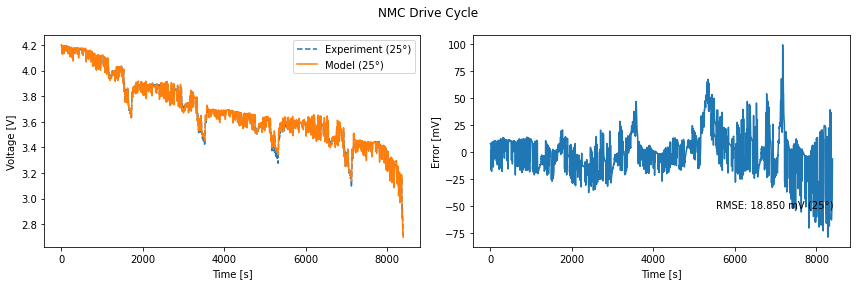

In [11]:
temperature = 25
filename = "NMC_25degC_DriveCycle.csv"
solve(temperature, filename, title="NMC Drive Cycle");

## C/20

RMSE = 15.940 mV 



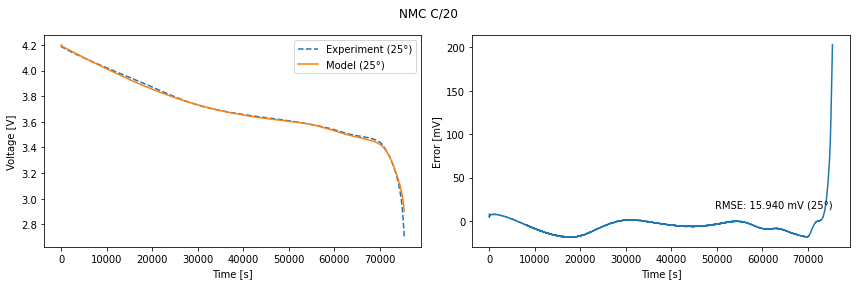

In [12]:
temperature = 25
filename = "NMC_25degC_Co20.csv"
solve(temperature, filename, title="NMC C/20");

## C/2

RMSE = 12.338 mV 



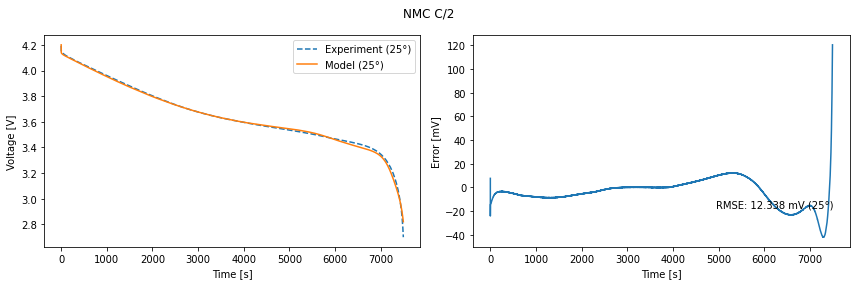

In [13]:
temperature = 25
filename = "NMC_25degC_Co2.csv"
solve(temperature, filename, title="NMC C/2");

## 1C

RMSE = 13.412 mV 



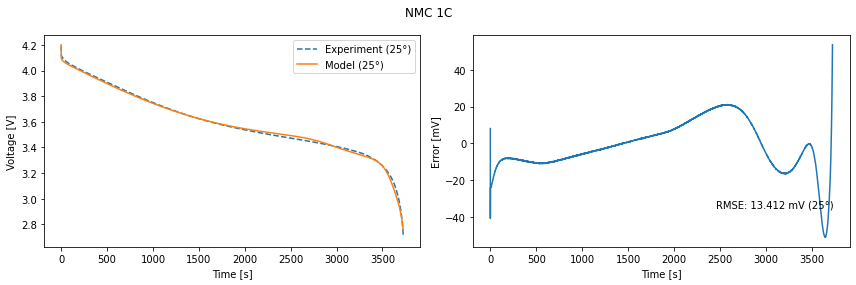

In [14]:
temperature = 25
filename = "NMC_25degC_1C.csv"
solve(temperature, filename, title="NMC 1C");

## 2C

RMSE = 24.685 mV 



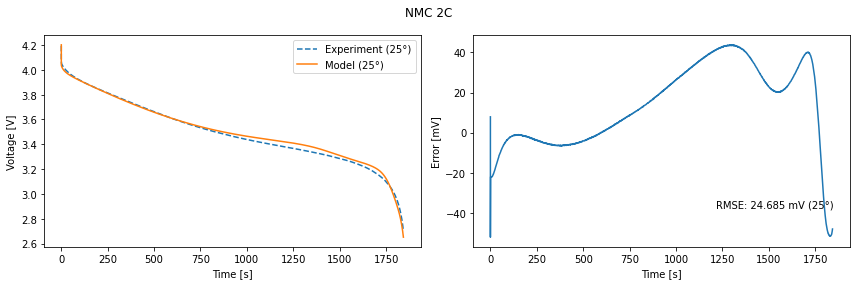

In [15]:
temperature = 25
filename = "NMC_25degC_2C.csv"
solve(temperature, filename, title="NMC 2C");